In [127]:
import numpy as np
import os
import sys
sys.path.append(r'C:\Users\Max Tost\Desktop\Notebooks\SPC Neural Network Project')
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import xgboost as xgb
import matplotlib.pyplot as plt # for plotting
%matplotlib widget
import seaborn as sns # for plotting
import pandas as pd # for data manipulation
from Models.load_data import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [166]:
# Load the shot data and replace nans with zeros to get arrays of equal length
path = r'C:\Users\Max Tost\Desktop\Notebooks\SPC Neural Network Project\Training_data'
features_list = os.listdir(os.path.join(path, r'features'))

# Replace 'path' and 'features_list' with your actual base path and list of feature file names.
X_train, y_train, X_test, y_test, x_mini_test, y_mini_test = load_all_data(path, features_list)


Key ECE_PF not in JETno89421.csv. Filling it with zeros.
Key RNT not in JETno85605.csv. Filling it with zeros.
Key ECE_PF not in JETno82811.csv. Filling it with zeros.
Key RNT not in JETno89795.csv. Filling it with zeros.
Key ECE_PF not in JETno97441.csv. Filling it with zeros.
Key RNT not in JETno84142.csv. Filling it with zeros.
Key ECE_PF not in JETno84142.csv. Filling it with zeros.
Key RNT not in JETno89317.csv. Filling it with zeros.
Key RNT not in JETno94219.csv. Filling it with zeros.
Key ECE_PF not in JETno82963.csv. Filling it with zeros.
Key ECE_PF not in JETno99275.csv. Filling it with zeros.
Key ECE_PF not in JETno86337.csv. Filling it with zeros.
Key ECE_PF not in JETno94357.csv. Filling it with zeros.
Key ECE_PF not in JETno89214.csv. Filling it with zeros.
Key DAI_EDG7 not in JETno83235.csv. Filling it with zeros.
Key DAI_EDG7 not in JETno82466.csv. Filling it with zeros.
Key ECE_PF not in JETno90644.csv. Filling it with zeros.
Key IPLA not in JETno95927.csv. Filling it

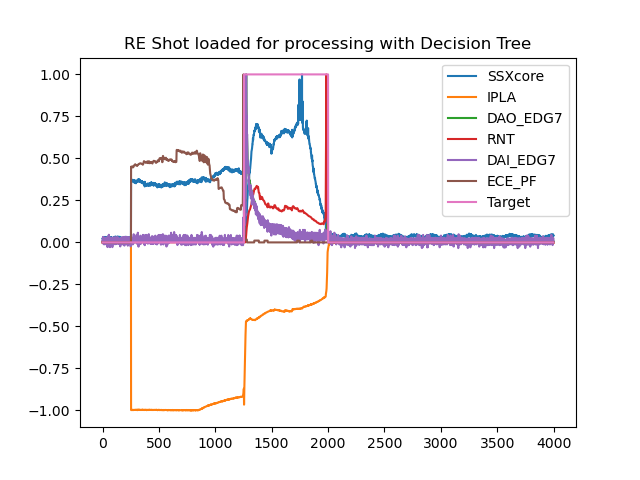

In [168]:
re_index = np.where(y_train == 1)[0][-1]
# Validation that data conversion worked: positive
features_sequence = ['SSXcore', 'IPLA', 'DAO_EDG7', 'RNT', 'DAI_EDG7', 'ECE_PF']
x_re = X_train[re_index-2000:re_index+2000, :].T
y_re = y_train[re_index-2000:re_index+2000]
plt.close()
for x, label in zip(x_re, features_sequence):
    plt.plot(x/max(np.absolute(x)), label = label)
plt.plot(y_re.T, label='Target')
plt.title(f'RE Shot loaded for processing with Decision Tree')
plt.legend()

In [169]:
from imblearn.over_sampling import SMOTE

# Instantiate SMOTE with a fixed random_state for reproducibility
smote = SMOTE(random_state=42)

# Apply SMOTE only on the training data
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [170]:
print('Before resampling the minority class, counts of appearences of 1 and 0 respectively')
print(len(np.where(y_train==1)[0]), len(np.where(y_train==0)[0]))
print('After oversampling the minority class')
print(len(np.where(y_train_res==1)[0]), len(np.where(y_train_res==0)[0]))

Before resampling the minority class, counts of appearences of 1 and 0 respectively
15100 974903
After oversampling the minority class
974903 974903


In [172]:
# Convert the data into DMatrix
dtrain = xgb.DMatrix(X_train_res, label=y_train_res)
dtest = xgb.DMatrix(X_test, label=y_test)
d_mini_test = xgb.DMatrix(x_mini_test, label=y_mini_test)

In [148]:
# Set parameters for binary classification
#{'eta': 0.12952757908461118, 'max_depth': 10, 'min_child_weight': 1, 'subsample': 0.9136547225140513, 'colsample_bytree': 0.7982666062021071, 'scale_pos_weight': 1.139133758423292}
params = {
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        "eta": 0.12952757908461118,
        "max_depth": 10,
        "min_child_weight": 1,
        "subsample": 0.9136547225140513,
        "colsample_bytree": 0.7982666062021071,
        "scale_pos_weight": 1.139133758423292
    }



In [161]:
num_rounds = 10
bst = xgb.train(params, dtrain, num_rounds)

In [162]:
# Predict on the train set
y_pred = bst.predict(dtrain)

# Convert probabilities to binary labels (assuming binary classification)
y_pred_labels = (y_pred > 0.5).astype(int)

# Calculate accuracy
accuracy = accuracy_score(y_train_res, y_pred_labels)
print(f"Accuracy: {accuracy:.2f}")


Accuracy: 0.99


In [163]:
from sklearn.metrics import classification_report

# Assuming you have predictions from your model
print(classification_report(y_train_res, y_pred_labels))

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99   1416768
         1.0       0.98      0.99      0.99   1416768

    accuracy                           0.99   2833536
   macro avg       0.99      0.99      0.99   2833536
weighted avg       0.99      0.99      0.99   2833536



In [164]:
# Predict on the test set
y_pred = bst.predict(dtest)

# Convert probabilities to binary labels (assuming binary classification)
y_pred_labels = (y_pred > 0.5).astype(int)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_labels)
print(f"Accuracy: {accuracy:.2f}")
#

Accuracy: 0.96


In [165]:
from sklearn.metrics import classification_report

# Assuming you have predictions from your model
print(classification_report(y_test, y_pred_labels))

              precision    recall  f1-score   support

         0.0       1.00      0.96      0.98    358850
         1.0       0.05      0.63      0.09      1151

    accuracy                           0.96    360001
   macro avg       0.52      0.80      0.53    360001
weighted avg       1.00      0.96      0.97    360001



## Parameter Optimization

In [173]:
import optuna # 
import xgboost as xgb
from sklearn.metrics import f1_score

# Assume X_train_res and y_train_res are your training data.
dtrain = xgb.DMatrix(X_train_res, label=y_train_res)

def objective(trial):
    # Define the hyperparameter search space

    params = {
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        "eta": trial.suggest_float("eta", 0.001, 0.3, log=True),  # Log scale for learning rate
        "max_depth": trial.suggest_int("max_depth", 3, 25),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
        "subsample": 0.9136547225140513,
        "colsample_bytree": 0.7982666062021071,
        "scale_pos_weight": 1.139133758423292
    }

    num_rounds = trial.suggest_int("num_rounds", 10, 150)

    bst = xgb.train(params, dtrain, num_rounds)

    # Predict on the test set
    y_mini_pred_labels = bst.predict(d_mini_test)

    # Assuming y_test and y_pred_labels are already defined
    f1 = f1_score(y_mini_test, (y_mini_pred_labels > 0.5).astype(int))
    
    return f1

# Paus hints for the report
# How I labeled the shots
# Splitting of data
# Composition of training and test data
# Performance with correct settings
# Time derivative of plasma current as extra and compare results
# Usually: Wrong parameters stops learning after few epochs, 

In [174]:
# Create a study and optimize the objective function
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

# Get the best hyperparameters
best_params = study.best_params
print(f"Best hyperparameters: {best_params}")

# Train the final model with the best hyperparameters
best_num_rounds = best_params.pop("num_rounds")
bst = xgb.train(best_params, dtrain, num_boost_round=best_num_rounds)

# Predict on the test set
y_pred = bst.predict(dtest)
y_pred_labels = (y_pred > 0.5).astype(int)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_labels)
print(f"Accuracy: {accuracy:.2f}")

# Calculate F1 score
f1 = f1_score(y_test, y_pred_labels)
print(f"F1 Score: {f1:.2f}")

[I 2025-02-07 19:21:37,123] A new study created in memory with name: no-name-447a8153-21c2-4304-adac-47aa61d29218
[I 2025-02-07 19:21:48,363] Trial 0 finished with value: 0.271244665592407 and parameters: {'eta': 0.005605233251174607, 'max_depth': 19, 'min_child_weight': 19, 'num_rounds': 30}. Best is trial 0 with value: 0.271244665592407.
[I 2025-02-07 19:22:16,036] Trial 1 finished with value: 0.4259247589640179 and parameters: {'eta': 0.04387430146365566, 'max_depth': 22, 'min_child_weight': 11, 'num_rounds': 90}. Best is trial 1 with value: 0.4259247589640179.
[I 2025-02-07 19:22:28,763] Trial 2 finished with value: 0.39619632969008206 and parameters: {'eta': 0.025164568947851202, 'max_depth': 14, 'min_child_weight': 16, 'num_rounds': 36}. Best is trial 1 with value: 0.4259247589640179.
[I 2025-02-07 19:22:36,147] Trial 3 finished with value: 0.1857603940576467 and parameters: {'eta': 0.004683939953690227, 'max_depth': 17, 'min_child_weight': 10, 'num_rounds': 21}. Best is trial 1 

Best hyperparameters: {'eta': 0.14384439355138182, 'max_depth': 18, 'min_child_weight': 3, 'num_rounds': 126}
Accuracy: 0.95
F1 Score: 0.32


In [178]:
# Calculate accuracy
y_pred = bst.predict(dtest)
y_pred_labels = (y_pred > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred_labels)
print(f"Accuracy: {accuracy:.2f}")

# Calculate F1 score
f1 = f1_score(y_test, y_pred_labels)
print(f"F1 Score: {f1:.2f}")

Accuracy: 0.95
F1 Score: 0.07
